# Setting and running Freyberg with pilot points...

### This should be super easy...

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP


changing model workspace...
   freyberg_pp
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/GIT/GW1876/activities/freyberg_pilot_points_1/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.4 4/01/2018                         
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/10/21 22:18:02

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 20

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:1607: PyemuWarning: Flow out (flout) of grouped segments will be aggregated... 
  warnings.warn("Flow out (flout) of grouped segments will be aggregated... ", PyemuWarning)


writing 'sfr_obs.config' to sfr_obs.config
                                    obsnme     obsval  weight    obgnme
c001fr05c04_19791231  c001fr05c04_19791231  29.135645     0.0  forehead
c001fr16c17_19791231  c001fr16c17_19791231  21.775225     0.0  forehead
starting interp point loop for 800 points
took 2.717853 seconds
noptmax: 0
noptmax: 8


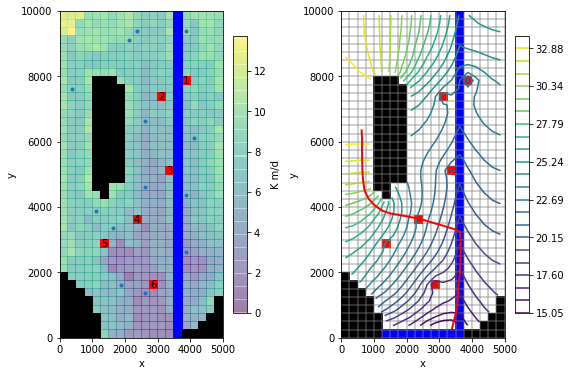

In [3]:
fs.plot_model(working_dir, pst_name)

## Let's go explore the files that were created for us.
### somethings to note:
### - what are the parameters that start with ``w``?
### - how many pilot points are there?
### - anything else look different?

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax

8

In [5]:
pst.pestpp_options

{'forecasts': 'travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231',
 'n_iter_base': '-1',
 'n_iter_super': '3',
 'lambda_scale_fac': '1.0',
 'upgrade_augment': 'false',
 'lambdas': '0.1,1.0,10.0'}

In [6]:
pst.npar

48

### Ok - let's run this bad boy...

In [7]:
os.chdir(working_dir)
pyemu.os_utils.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir('..')

In [8]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb"))).to_dataframe()

In [9]:
jco.loc[pst.nnz_obs_names,:]

,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,hk08,hk09,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
c001cr03c10_19700102,-0.039081,0.177838,-2.055140,-0.940144,-0.003293,-3.404520e-01,-1.007477,-0.634444,-0.037229,-0.567549,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr03c16_19700102,-0.004500,0.037668,0.061696,-0.363303,-0.003618,-8.782476e-03,-0.046655,-0.439281,-0.004172,-0.027788,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr04c09_19700102,0.010321,-0.171865,-2.065628,-0.596478,0.041076,-8.682341e-01,-1.909117,-0.642805,-0.066545,-1.038192,...,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13,-3.613311e-13
c001cr10c02_19700102,0.054449,-0.590625,-0.813018,-0.174279,-0.883260,-3.145101e+00,-2.258693,-0.459076,-0.552452,-1.687891,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr14c11_19700102,-0.003406,-0.132124,-0.335484,-0.114426,0.055795,3.268654e-01,-0.528603,-0.483350,0.107629,-0.392629,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr16c17_19700102,0.001318,0.003074,-0.002635,0.026516,0.001537,-1.870646e-03,-0.005490,0.040138,0.001642,0.002196,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr22c11_19700102,0.004173,-0.044369,-0.065757,-0.009651,-0.054047,-2.127724e-01,-0.169936,-0.036446,-0.048769,-0.123675,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr23c16_19700102,0.000332,0.000773,-0.000547,0.014712,0.000439,1.141505e-04,-0.001864,0.015591,0.000334,0.000659,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr25c05_19700102,0.007462,-0.075012,-0.105716,-0.019461,-0.100067,-3.944550e-01,-0.286740,-0.058332,-0.094130,-0.217691,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
c001cr27c07_19700102,0.006803,-0.068311,-0.096605,-0.017591,-0.090951,-3.590793e-01,-0.261490,-0.052633,-0.085128,-0.198361,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Let's see how we did:

In [10]:
pst.phi

122.89720713200954

### Wow - we slayed ``phi`` this time

In [11]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
c001cr03c10_19700102,c001cr03c10_19700102,calhead,26.262615,26.584846,-0.322231,5.00
c001cr03c16_19700102,c001cr03c16_19700102,calhead,23.463532,24.120941,-0.657409,5.00
c001cr04c09_19700102,c001cr04c09_19700102,calhead,28.126832,27.844124,0.282708,5.00
c001cr10c02_19700102,c001cr10c02_19700102,calhead,30.430534,30.655983,-0.225449,5.00
c001cr14c11_19700102,c001cr14c11_19700102,calhead,25.442033,24.742437,0.699596,5.00
c001cr16c17_19700102,c001cr16c17_19700102,calhead,20.064206,21.318924,-1.254718,5.00
c001cr22c11_19700102,c001cr22c11_19700102,calhead,24.333130,24.314194,0.018936,5.00
c001cr23c16_19700102,c001cr23c16_19700102,calhead,19.950425,20.726091,-0.775667,5.00
c001cr25c05_19700102,c001cr25c05_19700102,calhead,24.844271,25.246061,-0.401790,5.00


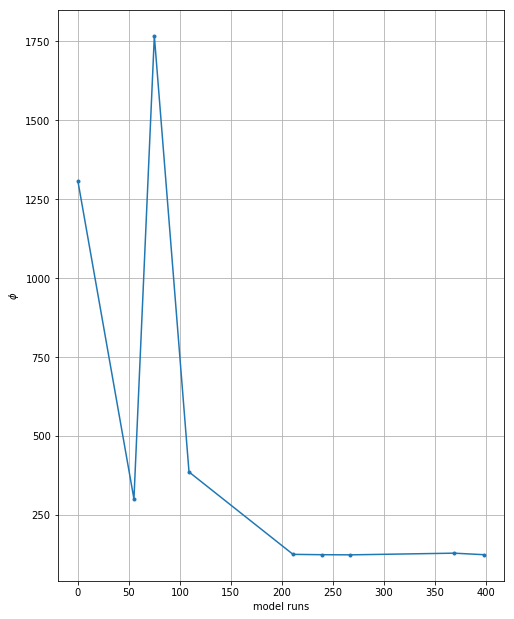

In [12]:
pst.plot(kind="phi_progress")

<Figure size 576x756 with 0 Axes>

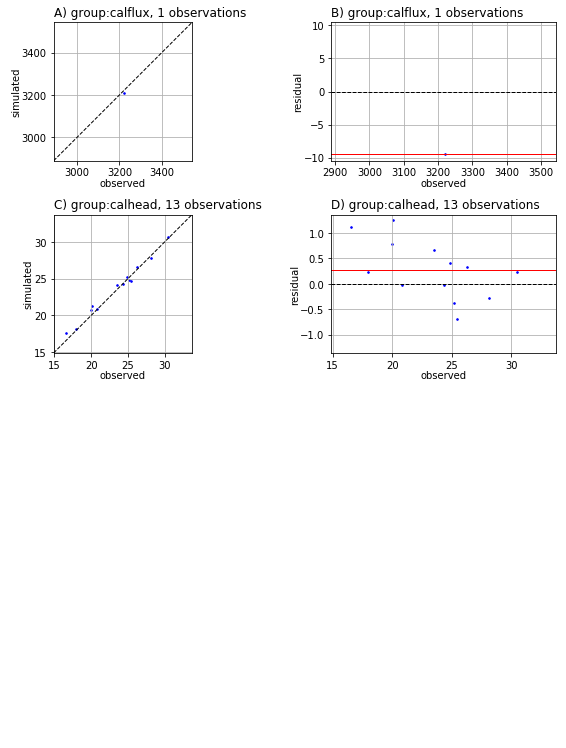

In [13]:
figs = pst.plot(kind="1to1")

### Sweet!  We nailed the heads!  This must be the perfect model in every way!  But, before we finalize the report, let's check out the parameter values:

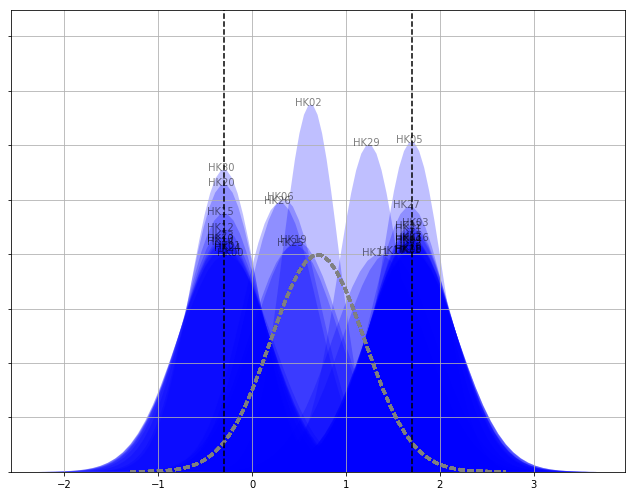

In [14]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
hk_pars = [p.upper() for p in pst.par_names if p.startswith("hk")]
df_hk = df_paru.loc[hk_pars,:]
ax = pyemu.plot_utils.plot_summary_distributions(df_hk,label_post=True)
mn = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parlbnd"])
mx = np.log10(pst.parameter_data.loc[hk_pars[0].lower(),"parubnd"])
ax.plot([mn,mn],ax.get_ylim(),"k--")
ax.plot([mx,mx],ax.get_ylim(),"k--")

### Lots of HK pars at their bounds...not a good sign.  We should probably see how the ``HK`` field looks:

In [22]:
os.chdir(working_dir)
pst.parrep(pst_name.replace(".pst",".parb"))
pst.write_input_files()
pyemu.geostats.fac2real("hkpp.dat",factors_file="hkpp.dat.fac",out_file="hk_layer_1.ref")
os.chdir("..")

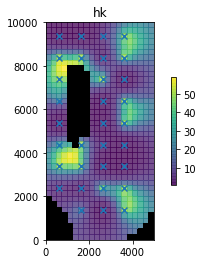

In [23]:
df_pp = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

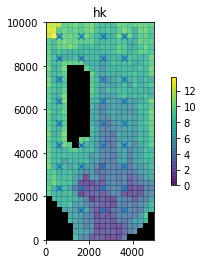

In [17]:
m.upw.hk[0] = os.path.join(fs.BASE_MODEL_DIR,"hk.truth.ref")
ax = m.upw.hk[0].plot(colorbar=True,alpha=0.5)
ax.scatter(df_pp.x,df_pp.y,marker='x')

### Something is wrong...how does the calibrated HK field have so much more variability than the "truth"?  We better checkout the forecasts:

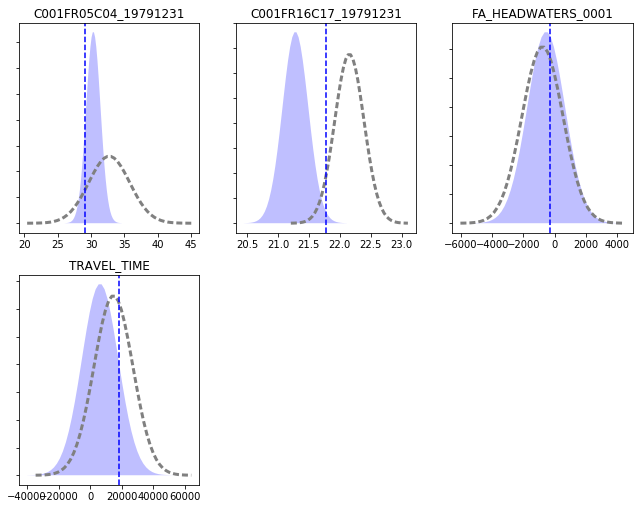

In [18]:
figs, axes = pyemu.plot_utils.plot_summary_distributions(os.path.join(working_dir,
                    pst_name.replace(".pst",".pred.usum.csv")),subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"b--")
    ax.set_ylim(ylim)

### Doh! What happened?  Answer: overfitting: we specified lots of parameters, so we are able to fit the observations really well - too well.  

### Even though we are able to measure water levels very precisely, the model has problems (model error), so we shouldn't expect the model to reproduce the observations so well.  But how do we control this overfitting??? 